# Logistic Regression

## Importing Processed Dataset

In [1]:
import pandas as pd
import pickle

In [2]:
# The final preprocessed files for building the models.
processed_dataset_path = 'data/2-imdb-movie-review-processed.csv'

# Save the transformed TF-IDF vectorized data into pickle format for loading into REST API.
pickle_vectorizer_model_path = 'models/vectorized-model.pkl'

# Save the trained model into pickle format for loading into REST API.
pickle_ml_lr_model_path = 'models/lr-ml-model.pkl'

data = pd.read_csv(processed_dataset_path)
data.head()

,review,sentiment
0,reviewer mention watch oz episode hook right e...,1
1,wonderful little production filming technique ...,1
2,I think wonderful way spend time hot summer we...,1
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,1


## Data Split

Class counter (stratified):
Entire-set  : Counter({1: 25000, 0: 25000}).
Train-set   : Counter({1: 20000, 0: 20000}).
Test-set    : Counter({0: 5000, 1: 5000}).


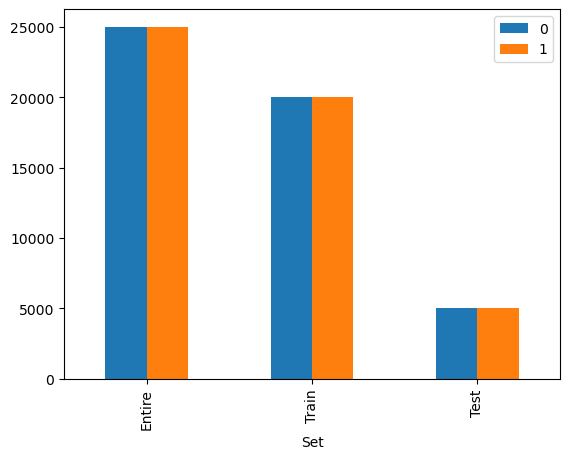

In [3]:
from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold

# Randomness to reproduce same splits for comparisons.
random_state = 42

# K-fold split for cv.
kfold_n_split = 5

# K-fold shuffle for cv.
kfold_shuffle = True

# A stratified K fold for cross-validation strategy - values are assigned from the evaluation helper module.
# When random state is enabled, shuffle has to be enabled to. Shuffle is done before the deterministic split (sklearn doc).
skfolds = StratifiedKFold(n_splits=kfold_n_split,
                          shuffle=kfold_shuffle,
                          random_state=random_state)

# Define features (X) and target (y)
X = data["review"]  # Use processed text column
y = data["sentiment"]  # Target labels (0 or 1)

train_test_split(X, y, test_size=0.20, stratify=y, random_state=random_state)

# Split dataset into train and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=random_state)

# Display the counter for '1' and '0' in y set before splitting.
print('Class counter (stratified):')
print(f'Entire-set  : {Counter(y)}.')
print(f'Train-set   : {Counter(y_train)}.')
print(f'Test-set    : {Counter(y_test)}.')

std_y_data = [['Entire', Counter(y).get(0), Counter(y).get(1)],
              ['Train', Counter(y_train).get(0), Counter(y_train).get(1)],
              ['Test', Counter(y_test).get(0), Counter(y_test).get(1)]]

pd.DataFrame(std_y_data, columns=['Set', '0', '1']).set_index('Set').plot.bar();

# TF-IDF Vectorization (Feature Extraction)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus. Otherwise, all features are used.
# Limits the max words used for building the model.
max_features = 50000

# TODO: Afif, please confirm and justify!
# Initialize TF-IDF Vectorizer
vectoriser = TfidfVectorizer(ngram_range=(1, 2), max_features=max_features)
#vectoriser = TfidfVectorizer(ngram_range=(1, 2))

# Fit TF-IDF on cleaned training data
vectoriser.fit(X_train)

print('Vectoriser fitted.')
print('No. of feature words:', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature words: 50000


In [5]:
# Apply transformation to convert text to TF-IDF vectors
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

print('Data Transformed.')


Data Transformed.


# Base Logistic Regression Model

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Initialize a base logistic regression model
lr = LogisticRegression(solver='liblinear', n_jobs=-1)

# Fit the model on the training data
lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

print("\n🔹 Classification Report:")
print(classification_report(y_test, y_pred))


/opt/anaconda3/envs/nlp-env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Accuracy: 0.8943
Precision: 0.8947
Recall: 0.8943
F1-score: 0.8943

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      5000
           1       0.88      0.91      0.90      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



## Base Model Confusion Matrics


🔹 Confusion Matrix:
[[4390  610]
 [ 447 4553]]


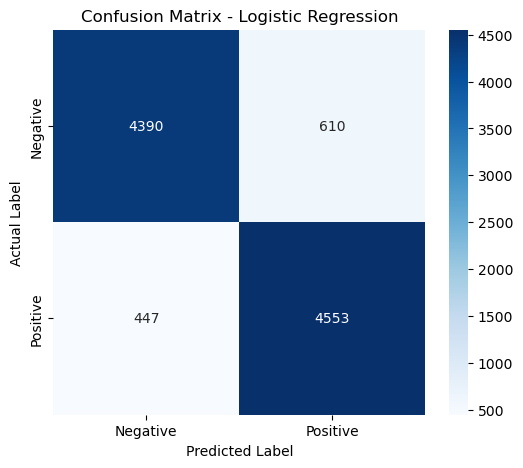

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print("\n🔹 Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


# Logistic Regression Hyper Parameter Tuning with RandomSearchCV

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Define parameter distribution for RandomizedSearchCV
param_dist = {
    'C': np.logspace(-3, 2, 50),         # Values from 0.001 to 100
    'penalty': ['l1', 'l2'],              # Regularisation type
    'solver': ['liblinear', 'saga'],      # Solvers that support l1 and l2 penalties
    'class_weight': [None, 'balanced'],   # Handle class imbalance
    'max_iter': [1000, 5000, 10000]        # Maximum iterations for convergence
}

# Set up RandomizedSearchCV with 5-fold cross-validation (using 20 iterations for speed)
rand_search = RandomizedSearchCV(
    LogisticRegression(),
    param_distributions=param_dist,
    n_iter=20,
    scoring='accuracy',
    cv=skfolds,  
    n_jobs=-1,
    random_state=random_state
)

# Fit RandomizedSearchCV on the training data (ensure X_train and y_train are defined)
rand_search.fit(X_train, y_train)

# Output the best hyperparameters found by RandomizedSearchCV
print("Randomized Search Best Parameters:")
print(rand_search.best_params_)


/opt/anaconda3/envs/nlp-env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/nlp-env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/nlp-env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Randomized Search Best Parameters:
{'solver': 'saga', 'penalty': 'l2', 'max_iter': 1000, 'class_weight': 'balanced', 'C': np.float64(3.7275937203149416)}


# Fine-tunes the best parameters found in RandomizedSearchCV with GridSearchCV

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

# Best parameters found from RandomizedSearchCV
best_params_rand = {
    'solver': 'saga',
    'penalty': 'l2',
    'max_iter': 1000,
    'class_weight': 'balanced',
    'C': 3.7275937203149416
}

# Define a refined parameter grid based on the best RandomizedSearchCV results
param_grid = {
    'C': np.linspace(best_params_rand['C'] * 0.8, best_params_rand['C'] * 1.2, 5),  # Narrower range around the best C
    'penalty': [best_params_rand['penalty']],  # Keep the best penalty
    'solver': [best_params_rand['solver']],  # Keep the best solver
    'class_weight': [best_params_rand['class_weight']],  # Keep the best class_weight
    'max_iter': [best_params_rand['max_iter'], best_params_rand['max_iter'] * 2]  # Test a slightly higher iteration count
}

# GridSearchCV with 5-fold cross-validation for fine-tuning
grid_search = GridSearchCV(
    LogisticRegression(),
    param_grid=param_grid,
    scoring='accuracy',
    cv=skfolds,
    n_jobs=-1,  # Use all available CPU cores
    verbose=1  # Show progress
)

# Fit the model
grid_search.fit(X_train, y_train)

# Retrieve the best hyperparameters from GridSearchCV
best_params_grid = grid_search.best_params_

# Best model from GridSearchCV
best_lr = grid_search.best_estimator_

# Predictions
y_pred_best = best_lr.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_best)
precision = precision_score(y_test, y_pred_best, average='weighted')
recall = recall_score(y_test, y_pred_best, average='weighted')
f1 = f1_score(y_test, y_pred_best, average='weighted')

# Print only the required outputs
print(f"Best Parameters: {best_params_grid}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}\n")

print("🔹 Classification Report:")
print(classification_report(y_test, y_pred_best))
print(best_lr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'C': np.float64(4.473112464377929), 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
Accuracy: 0.9017
Precision: 0.9019
Recall: 0.9017
F1-score: 0.9017

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      5000
           1       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

LogisticRegression(C=np.float64(4.473112464377929), class_weight='balanced',
                   max_iter=1000, solver='saga')


# Confusion Matrics

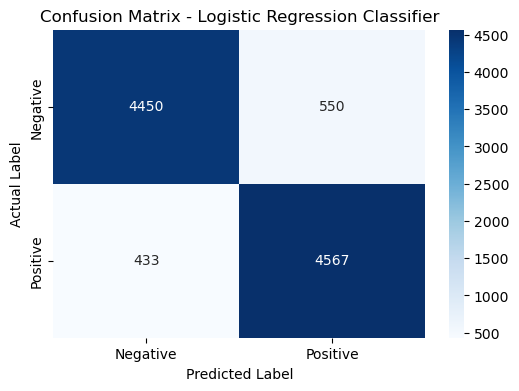

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predictions
y_pred_best = best_lr.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

# Define class labels
class_labels = ["Negative", "Positive"]

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# Add Labels
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Logistic Regression Classifier")

# Show the plot
plt.show()

# ROC Curve

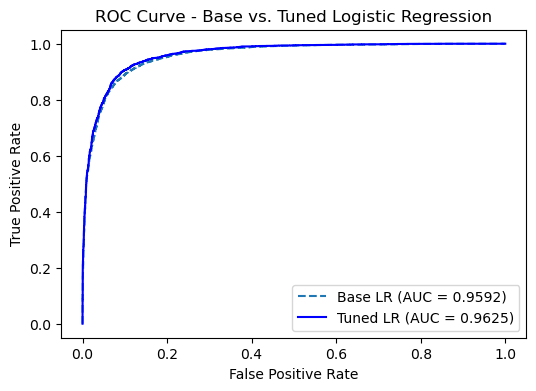

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute probabilities for both models
y_prob_base = LogisticRegression().fit(X_train, y_train).predict_proba(X_test)[:, 1]  # Base model
y_prob_tuned = best_lr.predict_proba(X_test)[:, 1]  # Tuned model

# Compute ROC curve and AUC for both models
fpr_base, tpr_base, _ = roc_curve(y_test, y_prob_base)
roc_auc_base = auc(fpr_base, tpr_base)

fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_prob_tuned)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)

# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr_base, tpr_base, linestyle='--', label=f"Base LR (AUC = {roc_auc_base:.4f})")
plt.plot(fpr_tuned, tpr_tuned, label=f"Tuned LR (AUC = {roc_auc_tuned:.4f})", color="blue")

# Add labels and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Base vs. Tuned Logistic Regression")
plt.legend(loc="lower right")

# Show the plot
plt.show()

# Save Best Model into Pickle

In [12]:
# Save the model into pickle file.
pickle.dump(best_lr, open(pickle_ml_lr_model_path, 'wb'))

In [13]:
# Load the model to verification.
loaded_lr = pickle.load(open(pickle_ml_lr_model_path, 'rb'))
result = loaded_lr.score(X_test, y_test)
print(result)

0.9017
